In [ ]:
# default_exp modeling.question_answering

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# modeling.question_answering

> This module contains custom models, loss functions, custom splitters, etc... for question answering tasks

In [ ]:
#export
import ast

import torch
from transformers import *
from fastai.text.all import *

from blurr.utils import *
from blurr.data.core import *
from blurr.data.question_answering import *
from blurr.modeling.core import *

logging.set_verbosity_error()

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.7.1
Using fastai 2.4
Using transformers 4.6.1


In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Question Answer

Given a document (context) and a question, the objective of these models is to predict the start and end token of the correct answer as it exists in the context.

Again, we'll use a subset of pre-processed SQUAD v2 for our purposes below.

In [ ]:
# full
# squad_df = pd.read_csv('./data/task-question-answering/squad_cleaned.csv'); len(squad_df)

# sample
squad_df = pd.read_csv('./squad_sample.csv'); len(squad_df)

1000

In [ ]:
squad_df.head(2)

,id,title,context,question,answers,ds_type,answer_text,is_impossible
0,56be85543aeaaa14008c9063,Beyoncé,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five G...",When did Beyonce start becoming popular?,"{'text': ['in the late 1990s'], 'answer_start': [269]}",train,in the late 1990s,False
1,56be85543aeaaa14008c9065,Beyoncé,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five G...",What areas did Beyonce compete in when she was growing up?,"{'text': ['singing and dancing'], 'answer_start': [207]}",train,singing and dancing,False


In [ ]:
pretrained_model_name = 'bert-large-uncased-whole-word-masking-finetuned-squad'
hf_model_cls = BertForQuestionAnswering

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=hf_model_cls)

# # here's a pre-trained roberta model for squad you can try too
# pretrained_model_name = "ahotrod/roberta_large_squad2"
# hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, 
#                                                                   model_cls=AutoModelForQuestionAnswering)

# # here's a pre-trained xlm model for squad you can try too
# pretrained_model_name = 'xlm-mlm-ende-1024'
# hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name,
#                                                                   model_cls=AutoModelForQuestionAnswering)

In [ ]:
squad_df = squad_df.apply(partial(pre_process_squad, hf_arch=hf_arch, hf_tokenizer=hf_tokenizer), axis=1)

In [ ]:
max_seq_len= 128

In [ ]:
squad_df = squad_df[(squad_df.tokenized_input_len < max_seq_len) & (squad_df.is_impossible == False)]

In [ ]:
#hide
squad_df.head(2)

,id,title,context,question,answers,ds_type,answer_text,is_impossible,tokenized_input,tokenized_input_len,tok_answer_start,tok_answer_end
214,56be97c73aeaaa14008c912a,Beyoncé,"Beyoncé announced a hiatus from her music career in January 2010, heeding her mother's advice, ""to live life, to be inspired by things again"". During the break she and her father parted ways as business partners. Beyoncé's musical break lasted nine months and saw her visit multiple European cities, the Great Wall of China, the Egyptian pyramids, Australia, English music festivals and various museums and ballet performances.",Beyonce would take a break from music in which year?,"{'text': ['2010'], 'answer_start': [60]}",train,2010,False,"[[CLS], beyonce, would, take, a, break, from, music, in, which, year, ?, [SEP], beyonce, announced, a, hiatus, from, her, music, career, in, january, 2010, ,, hee, ##ding, her, mother, ', s, advice, ,, "", to, live, life, ,, to, be, inspired, by, things, again, "", ., during, the, break, she, and, her, father, parted, ways, as, business, partners, ., beyonce, ', s, musical, break, lasted, nine, months, and, saw, her, visit, multiple, european, cities, ,, the, great, wall, of, china, ,, the, egyptian, pyramid, ##s, ,, australia, ,, english, music, festivals, and, various, museums, and, ballet...",99,23,24
215,56be97c73aeaaa14008c912b,Beyoncé,"Beyoncé announced a hiatus from her music career in January 2010, heeding her mother's advice, ""to live life, to be inspired by things again"". During the break she and her father parted ways as business partners. Beyoncé's musical break lasted nine months and saw her visit multiple European cities, the Great Wall of China, the Egyptian pyramids, Australia, English music festivals and various museums and ballet performances.",Which year did Beyonce and her father part business ways?,"{'text': ['2010'], 'answer_start': [60]}",train,2010,False,"[[CLS], which, year, did, beyonce, and, her, father, part, business, ways, ?, [SEP], beyonce, announced, a, hiatus, from, her, music, career, in, january, 2010, ,, hee, ##ding, her, mother, ', s, advice, ,, "", to, live, life, ,, to, be, inspired, by, things, again, "", ., during, the, break, she, and, her, father, parted, ways, as, business, partners, ., beyonce, ', s, musical, break, lasted, nine, months, and, saw, her, visit, multiple, european, cities, ,, the, great, wall, of, china, ,, the, egyptian, pyramid, ##s, ,, australia, ,, english, music, festivals, and, various, museums, and, b...",99,23,24


In [ ]:
vocab = list(range(max_seq_len))
# vocab = dict(enumerate(range(max_seq_len)));

In [ ]:
# account for tokenizers that pad on right or left side
trunc_strat = 'only_second' if (hf_tokenizer.padding_side == 'right') else 'only_first'

before_batch_tfm = HF_QABeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model,
                                             max_length=max_seq_len, 
                                             truncation=trunc_strat, 
                                             tok_kwargs={ 'return_special_tokens_mask': True })

blocks = (
    HF_TextBlock(before_batch_tfm=before_batch_tfm, input_return_type=HF_QuestionAnswerInput), 
    CategoryBlock(vocab=vocab),
    CategoryBlock(vocab=vocab)
)

def get_x(x):
    return (x.question, x.context) if (hf_tokenizer.padding_side == 'right') else (x.context, x.question)

dblock = DataBlock(blocks=blocks, 
                   get_x=get_x,
                   get_y=[ColReader('tok_answer_start'), ColReader('tok_answer_end')],
                   splitter=RandomSplitter(),
                   n_inp=1)

In [ ]:
dls = dblock.dataloaders(squad_df, bs=4)

In [ ]:
len(dls.vocab), dls.vocab[0], dls.vocab[1]

(2,
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 1

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,start/end,answer
0,"the letter beyonce signed focused on what issue? in 2015 beyonce signed an open letter which the one campaign had been collecting signatures for ; the letter was addressed to angela merkel and nkosazana dlamini - zuma, urging them to focus on women as they serve as the head of the g7 in germany and the au in south africa respectively, which will start to set the priorities in development funding before a main un summit in september 2015 that will establish new development goals for the generation.","(53, 54)",women
1,"how many people lost jobs when beyonce left the video game deal? the release of a video - game starpower : beyonce was cancelled after beyonce pulled out of a $ 100 million with gatefive who alleged the cancellation meant the sacking of 70 staff and millions of pounds lost in development. it was settled out of court by her lawyers in june 2013 who said that they had cancelled because gatefive had lost its financial backers. beyonce also has had deals with american express, nintendo ds and l'oreal since the age of 18.","(50, 52)",70 staff


### Training

Here we create a question/answer specific subclass of `HF_BaseModelCallback` in order to get all the start and end prediction.  We also add here a new loss function that can handle multiple targets

In [ ]:
#export
class HF_QstAndAnsModelCallback(HF_BaseModelCallback):  
    """The prediction is a combination start/end logits"""
    def after_pred(self):
        super().after_pred()
        self.learn.pred = (self.pred.start_logits, self.pred.end_logits)

And here we provide a custom loss function our question answer task, expanding on some techniques learned from here and here.

In fact, this new loss function can be used in many other multi-modal architectures, with any mix of loss functions.  For example, this can be ammended to include the `is_impossible` task, as well as the start/end token tasks in the SQUAD v2 dataset.

In [ ]:
#export
class MultiTargetLoss(Module):
    """Provides the ability to apply different loss functions to multi-modal targets/predictions"""
    def __init__(self, loss_classes=[CrossEntropyLossFlat, CrossEntropyLossFlat], loss_classes_kwargs=[{}, {}], 
                 weights=[1, 1], reduction='mean'):
        
        loss_funcs = [ cls(reduction=reduction, **kwargs) for cls, kwargs in zip(loss_classes, loss_classes_kwargs) ]
        store_attr(self=self, names='loss_funcs, weights')
        self._reduction = reduction
        
    # custom loss function must have either a reduction attribute or a reduction argument (like all fastai and
    # PyTorch loss functions) so that the framework can change this as needed (e.g., when doing lear.get_preds 
    # it will set = 'none'). see this forum topic for more info: https://bit.ly/3br2Syz
    @property
    def reduction(self): return self._reduction
    
    @reduction.setter
    def reduction(self, v): 
        self._reduction = v
        for lf in self.loss_funcs: lf.reduction = v

    def forward(self, outputs, *targets):
        loss = 0.
        for i, loss_func, weights, output, target in zip(range(len(outputs)), 
                                                         self.loss_funcs, self.weights,
                                                         outputs, targets):
            loss += weights * loss_func(output, target) 
                
        return loss
    
    def activation(self, outs): 
        acts = [ self.loss_funcs[i].activation(o) for i, o in enumerate(outs) ]
        return acts

    def decodes(self, outs):   
        decodes = [ self.loss_funcs[i].decodes(o) for i, o in enumerate(outs) ]
        return decodes


In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                cbs=[HF_QstAndAnsModelCallback],
                splitter=hf_splitter)

learn.loss_func=MultiTargetLoss()
learn.create_opt()                # -> will create your layer groups based on your "splitter" function
learn.freeze()

Notice above how I had to define the loss function *after* creating the `Learner` object.  I'm not sure why, but the `MultiTargetLoss` above prohibits the learner from being exported if I do.

In [ ]:
learn.summary()

HF_BaseModelWrapper (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 113 x 1024      
Embedding                                 31254528   False     
Embedding                                 524288     False     
Embedding                                 2048       False     
LayerNorm                                 2048       True      
Dropout                                                        
Linear                                    1049600    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
Dropout                                                        
Linear                                    1049600    False     
LayerNorm                                 2048       True      
Dropout                                                        
____________________________________________________________________________
            

In [ ]:
print(len(learn.opt.param_groups))

3


In [ ]:
x, y_start, y_end = dls.one_batch()
preds = learn.model(x)
len(preds),preds[0].shape

(2, torch.Size([4, 112]))

/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(minimum=0.004786301031708717, steep=0.0012022644514217973, valley=tensor(0.0008), slide=tensor(0.0007))

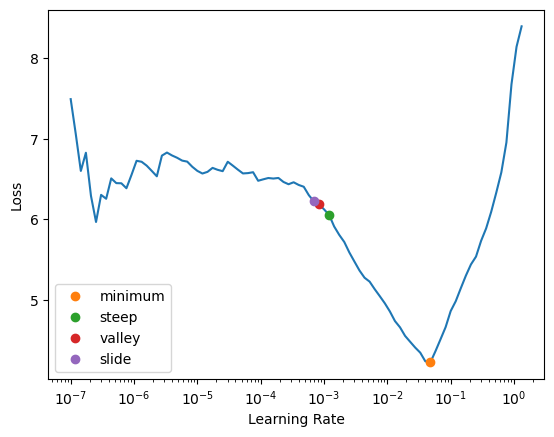

In [ ]:
#slow
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,time
0,4.245258,1.759054,00:04
1,2.392738,1.156932,00:04
2,1.658847,1.111220,00:04


### Showing results

Below we'll add in additional functionality to more intuitively show the results of our model.

In [ ]:
#export
@typedispatch
def show_results(x:HF_QuestionAnswerInput, y, samples, outs, learner, skip_special_tokens=True, 
                 ctxs=None, max_n=6, trunc_at=None, **kwargs):     
    
    hf_before_batch_tfm = get_blurr_tfm(learner.dls.before_batch)
    hf_tokenizer = hf_before_batch_tfm.hf_tokenizer
    
    res = L()
    for sample, input_ids, start, end, pred in zip(samples, x, *y, outs):
        txt = hf_tokenizer.decode(sample[0], skip_special_tokens=True)[:trunc_at]
        ans_toks = hf_tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)[start:end]
        pred_ans_toks = hf_tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)[int(pred[0]):int(pred[1])]
        
        res.append((txt,
                    (start.item(),end.item()), hf_tokenizer.convert_tokens_to_string(ans_toks),
                    (int(pred[0]),int(pred[1])), hf_tokenizer.convert_tokens_to_string(pred_ans_toks)))

    df = pd.DataFrame(res, columns=['text', 'start/end', 'answer', 'pred start/end', 'pred answer'])
    display_df(df[:max_n])
    return ctxs

In [ ]:
learn.show_results(learner=learn, skip_special_tokens=True, max_n=2, trunc_at=500)

,text,start/end,answer,pred start/end,pred answer
0,"beyonce released the song "" formation "" on which online music service? on february 6, 2016, one day before her performance at the super bowl, beyonce released a new single exclusively on music streaming service tidal called "" formation "".","(41, 42)",tidal,"(41, 42)",tidal
1,"what clothing line of beyonce drew peta criticism? in 2006, the animal rights organization people for the ethical treatment of animals ( peta ), criticized beyonce for wearing and using fur in her clothing line house of dereon. in 2011, she appeared on the cover of french fashion magazine l'officiel, in blackface and tribal makeup that drew criticism from the media. a statement released from a spokesperson for the magazine said that beyonce's look was "" far from the glamorous sasha fierce "" and","(42, 47)",house of dereon.,"(42, 46)",house of dereon


... and lets see how `Learner.blurr_predict` works with question/answering tasks

In [ ]:
inf_df = pd.DataFrame.from_dict([{
    'question': 'What did George Lucas make?',
    'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'   
}], 
    orient='columns')

learn.blurr_predict(inf_df.iloc[0])

[(('11', '13'),
  (#2) [tensor(11),tensor(13)],
  (#2) [tensor([1.2971e-07, 5.4632e-08, 4.3118e-09, 1.4866e-08, 8.1066e-09, 5.1815e-09,
        7.2038e-10, 1.2971e-07, 5.0283e-04, 2.5769e-05, 1.2658e-03, 9.9804e-01,
        1.1246e-04, 3.8943e-07, 1.1386e-05, 4.5824e-07, 1.8717e-05, 1.5357e-05,
        4.3513e-08, 4.8279e-06, 1.3044e-06, 1.3462e-07, 1.2781e-07]),tensor([2.3041e-03, 7.8627e-05, 6.2921e-06, 2.1366e-06, 1.0093e-05, 4.8622e-06,
        2.1415e-05, 2.3043e-03, 4.0043e-05, 1.8900e-04, 1.5386e-04, 2.7178e-05,
        7.7025e-02, 4.7673e-01, 2.1442e-02, 3.7941e-01, 1.1346e-04, 8.0640e-05,
        2.3729e-04, 2.5818e-04, 8.7608e-03, 2.8551e-02, 2.2499e-03])])]

In [ ]:
inf_df = pd.DataFrame.from_dict([
    {
        'question': 'What did George Lucas make?',
        'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'   
    }, {
        'question': 'What year did Star Wars come out?',
        'context': 'George Lucas created Star Wars in 1977. He directed and produced it.' 
    }, {
        'question': 'What did George Lucas do?',
        'context': 'George Lucas created Star Wars in 1977. He directed and produced it.' 
    }], 
    orient='columns')

learn.blurr_predict(inf_df)

[(('11', '13'),
  (#2) [tensor(11),tensor(13)],
  (#2) [tensor([1.2971e-07, 5.4632e-08, 4.3118e-09, 1.4866e-08, 8.1066e-09, 5.1815e-09,
        7.2038e-10, 1.2971e-07, 5.0283e-04, 2.5769e-05, 1.2658e-03, 9.9804e-01,
        1.1246e-04, 3.8943e-07, 1.1386e-05, 4.5824e-07, 1.8717e-05, 1.5357e-05,
        4.3513e-08, 4.8279e-06, 1.3044e-06, 1.3462e-07, 1.2781e-07, 4.3198e-10,
        5.3803e-10]),tensor([2.3041e-03, 7.8627e-05, 6.2921e-06, 2.1366e-06, 1.0093e-05, 4.8622e-06,
        2.1415e-05, 2.3043e-03, 4.0043e-05, 1.8900e-04, 1.5386e-04, 2.7178e-05,
        7.7025e-02, 4.7673e-01, 2.1442e-02, 3.7941e-01, 1.1346e-04, 8.0640e-05,
        2.3729e-04, 2.5818e-04, 8.7607e-03, 2.8551e-02, 2.2499e-03, 1.5759e-06,
        9.7392e-07])]),
 (('16', '17'),
  (#2) [tensor(16),tensor(17)],
  (#2) [tensor([9.5038e-07, 5.2476e-06, 7.7484e-08, 4.6734e-08, 4.8204e-08, 3.2538e-08,
        5.3975e-08, 6.6650e-08, 2.4325e-08, 9.5044e-07, 2.2383e-06, 2.5617e-06,
        4.3533e-06, 9.4893e-06, 3.0604e-06,

In [ ]:
inp_ids = hf_tokenizer.encode('What did George Lucas make?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[11:13]

['star', 'wars']

Note that there is a bug currently in fastai v2 (or with how I'm assembling everything) that currently prevents us from seeing the decoded predictions and probabilities for the "end" token.

In [ ]:
inf_df = pd.DataFrame.from_dict([{
    'question': 'When was Star Wars made?',
    'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'
}], 
    orient='columns')

test_dl = dls.test_dl(inf_df)
inp = test_dl.one_batch()[0]['input_ids']
probs, _, preds = learn.get_preds(dl=test_dl, with_input=False, with_decoded=True)

In [ ]:
hf_tokenizer.convert_ids_to_tokens(inp.tolist()[0], 
                                   skip_special_tokens=False)[torch.argmax(probs[0]):torch.argmax(probs[1])]

['1977']

We can unfreeze and continue training like normal

In [ ]:
learn.unfreeze()

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=slice(1e-7, 1e-4))

epoch,train_loss,valid_loss,time
0,0.953578,1.057078,00:08
1,0.741695,1.026770,00:08
2,0.616375,1.009519,00:08


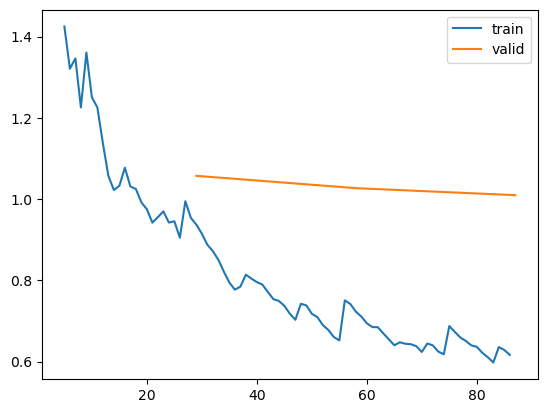

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=100)

,text,start/end,answer,pred start/end,pred answer
0,"beyonce released the song "" formation "" on which online music service? on february 6, 2016, one day","(41, 42)",tidal,"(41, 42)",tidal
1,"what was the name of the poet chopin became acquainted with in paris? in paris, chopin encountered a","(91, 95)",adam mickiewicz,"(91, 95)",adam mickiewicz


In [ ]:
learn.blurr_predict(inf_df.iloc[0])

[(('14', '15'),
  (#2) [tensor(14),tensor(15)],
  (#2) [tensor([1.0962e-07, 6.5032e-08, 1.4101e-08, 1.2711e-08, 1.0755e-08, 2.9241e-08,
        4.7287e-09, 1.0962e-07, 2.4220e-06, 9.6392e-07, 7.5830e-06, 4.9059e-06,
        8.4087e-07, 9.6804e-04, 9.9901e-01, 8.3142e-07, 9.3792e-08, 6.7916e-08,
        8.3141e-09, 5.3633e-08, 1.2143e-07, 8.2509e-08, 1.0807e-07]),tensor([3.2899e-04, 1.1594e-05, 5.1233e-06, 2.3293e-06, 4.0389e-06, 2.9255e-06,
        6.9592e-06, 3.2899e-04, 2.2977e-05, 3.0044e-05, 4.7082e-05, 9.6017e-06,
        4.2508e-05, 1.3554e-04, 9.9463e-04, 9.9694e-01, 6.1252e-04, 1.9754e-05,
        1.9442e-05, 1.5386e-05, 4.4834e-05, 5.1710e-05, 3.2592e-04])])]

In [ ]:
preds, pred_classes, probs = zip(*learn.blurr_predict(inf_df.iloc[0]))
preds

(('14', '15'),)

In [ ]:
inp_ids = hf_tokenizer.encode('When was Star Wars made?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[int(preds[0][0]):int(preds[0][1])]

['1977']

### Inference

Note that I had to replace the loss function because of the above-mentioned issue to exporting the model with the `MultiTargetLoss` loss function.  After getting our inference learner, we put it back and we're good to go!

In [ ]:
export_name = 'q_and_a_learn_export'

In [ ]:
learn.loss_func = CrossEntropyLossFlat()
learn.export(fname=f'{export_name}.pkl')

In [ ]:
inf_learn = load_learner(fname=f'{export_name}.pkl')
inf_learn.loss_func = MultiTargetLoss()

inf_df = pd.DataFrame.from_dict([
    {
        'question': 'What did George Lucas make?',
        'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'   
    }, {
        'question': 'What year did Star Wars come out?',
        'context': 'George Lucas created Star Wars in 1977. He directed and produced it.' 
    }, {
        'question': 'What did George Lucas do?',
        'context': 'George Lucas created Star Wars in 1977. He directed and produced it.' 
    }], 
    orient='columns')

inf_learn.blurr_predict(inf_df)

[(('11', '13'),
  (#2) [tensor(11),tensor(13)],
  (#2) [tensor([9.9726e-08, 6.5714e-08, 4.1207e-09, 1.0171e-08, 6.3904e-09, 6.1866e-09,
        7.4012e-10, 9.9731e-08, 9.5022e-05, 8.5999e-06, 7.3826e-04, 9.9901e-01,
        1.2175e-04, 1.1253e-07, 7.6610e-06, 1.6855e-07, 4.9347e-06, 6.5961e-06,
        2.2110e-08, 2.4666e-06, 4.8582e-07, 6.2157e-08, 9.6503e-08, 4.2477e-10,
        5.4790e-10]),tensor([8.6856e-04, 3.1412e-05, 2.8184e-06, 1.0542e-06, 2.9256e-06, 1.4953e-06,
        5.7687e-06, 8.6860e-04, 1.6002e-05, 3.9944e-05, 5.7251e-05, 1.1663e-05,
        3.0383e-02, 7.8027e-01, 5.5434e-03, 1.7301e-01, 5.0527e-05, 4.3134e-05,
        1.0219e-04, 9.5247e-05, 2.8523e-03, 4.8909e-03, 8.4483e-04, 6.5463e-07,
        4.3239e-07])]),
 (('16', '17'),
  (#2) [tensor(16),tensor(17)],
  (#2) [tensor([4.0391e-07, 2.5282e-06, 4.5787e-08, 2.6189e-08, 2.8409e-08, 2.0624e-08,
        3.0818e-08, 3.8668e-08, 1.6358e-08, 4.0394e-07, 7.1291e-07, 8.9311e-07,
        1.3645e-06, 2.8566e-06, 1.3330e-06,

In [ ]:
inp_ids = hf_tokenizer.encode('What did George Lucas make?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[11:13]

['star', 'wars']

... and onnx works here too

In [ ]:
# #slow
# learn.blurr_to_onnx(export_name)

In [ ]:
# #slow
# onnx_inf = blurrONNX(export_name)

In [ ]:
# #slow
# onnx_inf.predict(inf_df)

## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01_modeling-core.ipynb.
Converted 02_data-language-modeling.ipynb.
Converted 02_modeling-language-modeling.ipynb.
Converted 03_data-token-classification.ipynb.
Converted 03_modeling-token-classification.ipynb.
Converted 04_data-question-answering.ipynb.
Converted 04_modeling-question-answering.ipynb.
Converted 10_data-seq2seq-core.ipynb.
Converted 10_modeling-seq2seq-core.ipynb.
Converted 11_data-seq2seq-summarization.ipynb.
Converted 11_modeling-seq2seq-summarization.ipynb.
Converted 12_data-seq2seq-translation.ipynb.
Converted 12_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-multilabel.ipynb.
Converted index.ipynb.
